---
# 11.5 Parametric curves
---

In this last section, we look at interpolating a set of points 

$$(x_0, y_0), \ldots, (x_n, y_n)$$

by a **parametric curve**

$$x = x(t), \quad y = y(t), \quad t \in [a,b].$$

A simple approach is to separately interpolate the $x$-coordinate data

$$(t_0, x_0), \ldots, (t_n, x_n)$$

and the $y$-coordinate data

$$(t_0, y_0), \ldots, (t_n, y_n)$$

where $t_i = i/n \in [0, 1]$.

---

## Example

Let's try interpolating a number of randomly generated points.

**Lagrange interpolation** is ideal here since we have two sets of data having the same $t$-values. Thus, we only need to compute the Lagrange weights once to do polynomial interpolation twice.

In [1]:
# Defining the Lagrange interpolation functions

function lagrangeweights(x::Vector{T}) where T

    n = length(x) - 1
    
    w = ones(T, n+1)  # An array of ones, the same size and type as x
    for j=1:n+1
        for i=1:n+1
            if i ≠ j
                w[j] *= (x[j] - x[i]) 
            end
        end
        try 
            # If w is an Integer array, 
            # this will throw an InexactError
            w[j] = 1/w[j] 
        catch
            # We give a useful warning here
            error("Must use either AbstractFloat or Rational array.")
        end
    end
    
    return w
end

function lagrangeeval(xspan::AbstractVector, w::Vector, x::AbstractVector, y::Vector)
    
    n = length(x)
    
    top = zero(xspan)
    bottom = zero(xspan)
    exact = zeros(Int, length(xspan))

    for j=1:n
        xdiff = xspan .- x[j]
        temp = w[j]./xdiff
        top += temp*y[j]
        bottom += temp
        
        exact[xdiff .== 0.0] .= j  # exact[i] = j if xspan[i] = x[j]
    end
    
    p = top./bottom

    iinds = findall(exact .!= 0)  # gives the indices i of xspan that equal some x[j]
    jinds = exact[iinds]          # gives the corresponding j indices
    p[iinds] = y[jinds]           # sets any NaNs in p to the correct values from y
    
    return p  
end

lagrangeeval(xx::Real, w::Vector, x::AbstractVector, y::Vector) = lagrangeeval([xx], w, x, y)[1]

lagrangeeval (generic function with 2 methods)

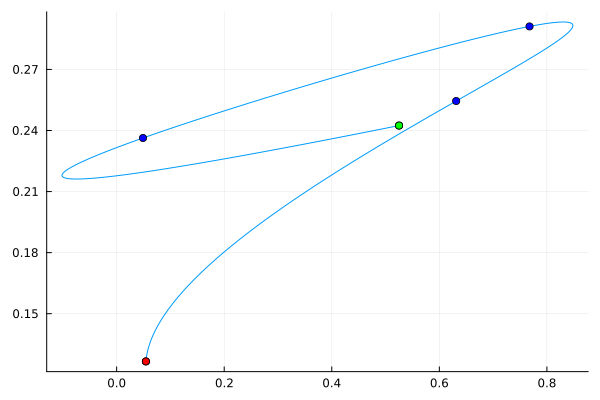

In [10]:
using Plots

n = 4
x, y = rand(n+1), rand(n+1)
t = range(0, 1, length=n+1)
t = collect(t)

tt = range(0, 1, length=1000)
w = lagrangeweights(t)  # Just need to compute weights once
px = lagrangeeval(tt, w, t, x)
py = lagrangeeval(tt, w, t, y)

plot(legend=:none)
plot!(px, py)
scatter!(x, y, c=:blue)
scatter!([x[1]], [y[1]], c=:lime)
scatter!([x[end]], [y[end]], c=:red)

---

# Parametric piecewise cubic Hermite polynomials

Piecewise interpolation using cubic Hermite polynomials provides a much better solution.

We will draw a curve between two points $(x_0,y_0)$ and $(x_1,y_1)$, and we will use **two guidepoints** $(x_0+\alpha_0,y_0+\beta_0)$ and $(x_1-\alpha_1,y_1-\beta_1)$ to specify the slope of the curve at the endpoints.

Specifically, **Bézier polynomials** are cubic Hermite polynomials $p_x(t)$ and $p_y(t)$ that satisfy

$$
\begin{align}
p_x(0) &= x_0, &p_x(1) &= x_1, &p_x'(0) &= 3\alpha_0, &p_x'(1) &= 3\alpha_1\\
p_y(0) &= y_0, &p_y(1) &= y_1, &p_y'(0) &= 3\beta_0,  &p_y'(1) &= 3\beta_1\\
\end{align}
$$

The factor of 3 is there to ensure that the curve lies within the convex hull of the four points.

It can be shown that

$$
\begin{align}
p_x(t) &= \big(2(x_0 - x_1) + 3(\alpha_0 + \alpha_1)\big) t^3 + \big(3(x_1 - x_0) - 3(\alpha_1 + 2\alpha_0)\big) t^2 + 3\alpha_0 t + x_0\\
p_y(t) &= \big(2(y_0 - y_1) + 3(\beta_0 + \beta_1)\big) t^3 + \big(3(y_1 - y_0) - 3(\beta_1 + 2\beta_0)\big) t^2 + 3\beta_0 t + y_0\\
\end{align}
$$


---

## Example

Let's form the Bézier curve from four random points.

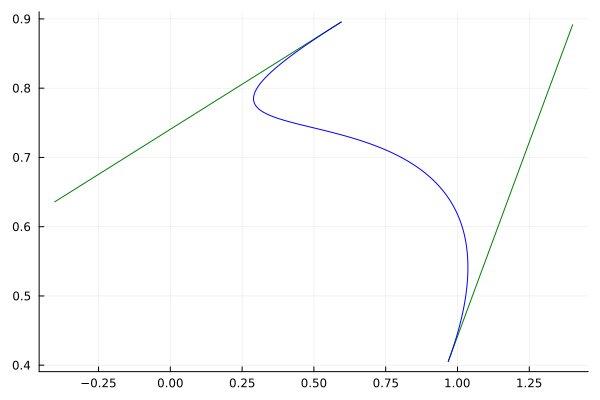

In [14]:
using Plots

x, y = rand(2), rand(2)
α, β = rand(2), rand(2)

tt = range(0, 1, length=1000)

plot(legend=:none)

plot!([x[1], x[1]+α[1]], [y[1], y[1]+β[1]], c=:green)
plot!([x[2], x[2]-α[2]], [y[2], y[2]-β[2]], c=:green)

px = (2(x[1]-x[2]) .+ 3(α[1]+α[2]))*tt.^3 .+ (3(x[2]-x[1]) .- 3(α[2]+2α[1]))*tt.^2 .+ 3α[1]*tt .+ x[1]
py = (2(y[1]-y[2]) .+ 3(β[1]+β[2]))*tt.^3 .+ (3(y[2]-y[1]) .- 3(β[2]+2β[1]))*tt.^2 .+ 3β[1]*tt .+ y[1]

plot!(px, py, c=:blue)

---

## `bezier.jl`: an interactive example

---

Save the following code in a file called `bezier.jl`.

---

```julia
using PyPlot

# This function creates a blank figure
function figreset()
    ax = [0, 1, 0, 1]
    clf(); axis(ax)
    title("Click to place guidepoints")
end

# Create the initial figure window
figreset()

# Tell user what to do
println("Click figure to place guidepoints.")

# Keep doing this forever
while true

    # Collect the four guidepoints from user input
    gp = zeros(4, 2)
    for i=1:4
        p = ginput()[1]
        gp[i, :] = [p[1], p[2]]
        figreset()
        if i < 3
            plot(gp[1:i,1], gp[1:i,2], "go-")
        else
            plot(gp[1:2,1], gp[1:2,2], "go-")
            plot(gp[3:i,1], gp[3:i,2], "go-")
        end
    end

    # Define x and y
    x = gp[[1,3],1]
    y = gp[[1,3],2]

    # Define α and β
    α = [gp[2,1] - x[1], x[2] - gp[4,1]]
    β = [gp[2,2] - y[1], y[2] - gp[4,2]]

    # Plot the guidepoints
    figreset()
    plot([x[1], x[1]+α[1]], [y[1], y[1]+β[1]], "g-")
    plot([x[2], x[2]-α[2]], [y[2], y[2]-β[2]], "g-")

    # Plot Bézier curve
    tt = range(0, 1, length=1000)
    px = (2(x[1]-x[2]) .+ 3(α[1]+α[2]))*tt.^3 .+
         (3(x[2]-x[1]) .- 3(α[2]+2α[1]))*tt.^2 .+
         3α[1]*tt .+ x[1]
    py = (2(y[1]-y[2]) .+ 3(β[1]+β[2]))*tt.^3 .+
         (3(y[2]-y[1]) .- 3(β[2]+2β[1]))*tt.^2 .+
         3β[1]*tt .+ y[1]
    plot(px, py)

end
```

---

 Start an interactive Julia session and execute `include("bezier.jl")` at the `julia>` prompt.

---

                   _
       _       _ _(_)_     |  Documentation: https://docs.julialang.org
      (_)     | (_) (_)    |
       _ _   _| |_  __ _   |  Type "?" for help, "]?" for Pkg help.
      | | | | | | |/ _` |  |
      | | |_| | | | (_| |  |  Version 1.8.5 (2023-01-08)
     _/ |\__'_|_|_|\__'_|  |  Official https://julialang.org/ release
    |__/                   |

    julia> include("bezier.jl")
    Click figure to place guidepoints.

---

[SVG Cubic Bezier Commands](https://www.w3.org/TR/SVG/paths.html#PathDataCubicBezierCommands)

---

# Celeste

The hanging cables in the first chapter of Celeste are drawn and animated using Bézier curves.

[Celeste YouTube video](https://youtu.be/HV0yJ2cae9Q?t=20) showing the animation of the hanging cables.

[YouTube video](https://youtu.be/u-nSjhIgmXc?t=2925): Celeste devs discuss using Bézier curves draw and animate hanging cables.

![Celeste](https://oyster.ignimgs.com/mediawiki/apis.ign.com/celeste/a/ac/180124_CI_C1_S2.png?width=960)

---